In [62]:
import dask.array
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from os import path, listdir

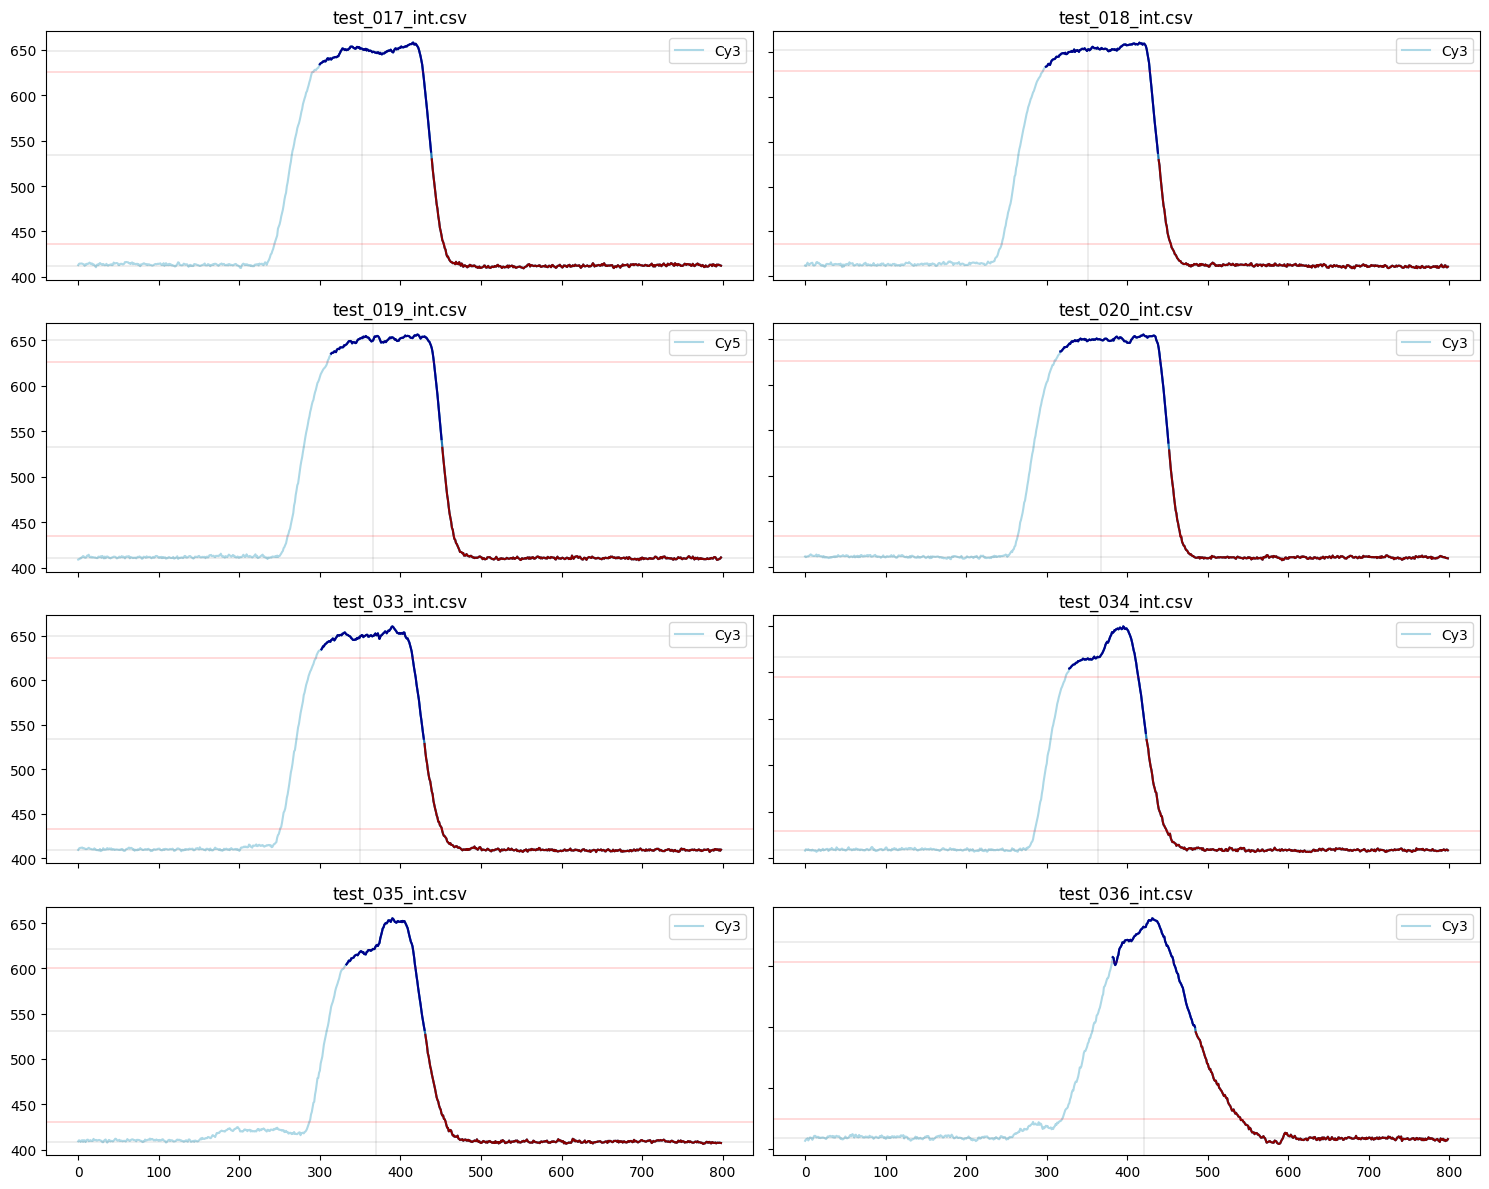

In [63]:
dir = r"sm_particle_counter/test/data/intensity"
lkw = dict(color="k", lw=0.1)
lkwr = dict(color="r", lw=0.2)


N = len(listdir(dir))
ncol = 2
nrow = (N-1) // ncol + 1
fig, axs = plt.subplots(nrow, ncol, figsize=(15,3*nrow), sharey=False, sharex=True)
for i in range(N):
    col = i % ncol
    row = i // ncol
    fn = listdir(dir)[i]
    df = pd.read_csv(path.join(dir, fn), index_col=0)

    # What channel contains the strongest signal?
    channel = df.apply(np.ptp, axis=0).idxmax()

    ax = axs[row, col]
    ax.plot(df[channel], label=channel, color="lightblue")
    ax.set_title(fn)
    ax.label_outer()

# Analysis
    int_np = df[channel].to_numpy()
    half_max = 0.5 * (int_np.min() + int_np.max())
    ax.axhline(half_max, **lkw)
    peak_idx = np.where(int_np > half_max)[0]
    peak_margin = int(np.quantile(peak_idx, 0.2))
    ax.axvline(peak_idx.mean(), **lkw)

    front = df.iloc[peak_margin:]   # back = df.iloc[peak_margin:]  and peak_margin = int(np.quantile(peak_idx, 0.2))
    ax.plot(front.index, front[channel])
    front_low = front[front[channel] <= half_max]
    front_high = front[front[channel] > half_max]
    ax.plot(front_high.index, front_high[channel], color="darkblue")
    ax.plot(front_low.index, front_low[channel], color="darkred")
    low = np.median(front_low[channel])
    high = np.median(front_high[channel])
    ten_p = 0.1 * (high - low)
    t_low, t_high = low+ten_p, high-ten_p
    [ax.axhline(i, **lkw) for i in [low, high]]
    [ax.axhline(i, **lkwr) for i in [t_low, t_high]];
    ax.legend()
fig.tight_layout()

    # Now smooth with savgol and then find intersection with t_low and t_high




# Notes
Look at the standard deviation of mean intensity across the first 10 frames. This metric should give an idea how noisy the data are. Apply savgol filter with window length proportional to the noise level. Add as a new column (Cy3 -> Cy3s?).

After that, split the data into four sets: front bottom, front top, back bottom, back top. Use median of each subset to get the baseline level. The code to analyze front and back of the signal will be almost identical, so wrap it into functions.

Make sure that it does not crash if the data subset is empty.

Make sure everything works for arbitrary number of spectral channels. In this case, only the channel with the biggest ptp is used for the rise/fall time analysis.

# Some metatada magic below

In [219]:
import re
from PIL import Image
from PIL.TiffTags import TAGS

fn = r'D:\2023-06 injection test data\test_001.tif'
#fn = r'D:\2023-06 injection test data\02 10ms 500mW rinsing at frame 50000.tif'
#fn = r'D:\2023-06 injection test data\bead_align000.tif'

#fn = r"sm_particle_counter\test\data\DNA incubation.tif"

print(read_metadata(fn))

FlashGordon=1.2
hardware=
binning=2x2
frameTime=0.002000
exposureTime=0.002000
channel1.name=Cy3
channel1.wavelength=532
channel1.photonsPerCount=0.210000
channel2.name=Cy5
channel2.wavelength=640
channel2.photonsPerCount=0.210000
fieldArrangement=[1,2]
StageX=-807.00
StageY=0.00
power_mW=3117.1 
width=2304
height=184


In [220]:
import re
from PIL import Image
import numpy as np


def read_metadata(tiff_file):
    """
    Read ImageDescription metadata from the tiff file as a block of text
    """
    IMAGEDESC = 270
    IMAGEWIDTH = 256
    IMAGELENGTH = 257
    with Image.open(tiff_file) as img:
        tags = img.tag.items()
        d = {k: v for (k, v) in img.tag.items()}
        txt = d[IMAGEDESC][0]
        txt += f"\nwidth={d[IMAGEWIDTH][0]}"
        txt += f"\nheight={d[IMAGELENGTH][0]}"
    return txt

def parse_metadata(meta_text):
    """
    Parse text block containing metadata in <key>=<value> format
    """
    meta = dict(u.strip().replace('\x00','').split('=', 1) for u in meta_text.splitlines())
    meta["width"] = int(meta["width"])
    meta["height"] = int(meta["height"])
    meta = get_channel_info(meta)
    return meta

def get_channel_info(metadata):
    """
    Extract information about arrangement of spectral channels from the metadata dict
    """
    fields = metadata["fieldArrangement"]
    N = len(re.findall("[1-4]", fields))
    metadata["n_channels"] = N

    f = re.findall('[\d|;]', fields)

    W, H = metadata['width'], metadata['height']
    if N >= 2:
        W = W//2
    if N >= 3:
        H = H//2

    metadata["channels"] = []
    for m in range(1, N+1):
        ch = metadata[f"channel{m}.name"]
        metadata["channels"].append(ch)
        x, y, = 0, 0

        for token in f:
            if str(m) == token:
                metadata[f"{ch}_slice"] = np.s_[..., H*y:H*(y + 1), W*x:W*(x + 1)]
            x += 1
            if token == ';':
                y += 1
                x = 0

    return metadata


In [221]:
parse_metadata(read_metadata(fn))

{'FlashGordon': '1.2',
 'hardware': '',
 'binning': '2x2',
 'frameTime': '0.002000',
 'exposureTime': '0.002000',
 'channel1.name': 'Cy3',
 'channel1.wavelength': '532',
 'channel1.photonsPerCount': '0.210000',
 'channel2.name': 'Cy5',
 'channel2.wavelength': '640',
 'channel2.photonsPerCount': '0.210000',
 'fieldArrangement': '[1,2]',
 'StageX': '-807.00',
 'StageY': '0.00',
 'power_mW': '3117.1',
 'width': 2304,
 'height': 184,
 'n_channels': 2,
 'channels': ['Cy3', 'Cy5'],
 'Cy3_slice': (Ellipsis, slice(0, 184, None), slice(0, 1152, None)),
 'Cy5_slice': (Ellipsis, slice(0, 184, None), slice(1152, 2304, None))}

In [222]:
meta = parse_metadata(read_metadata(fn))

In [236]:
import dask
from dask_image import imread
stack = imread.imread(fn)
stack[meta["Cy3_slice"]]

dask.array<getitem, shape=(600, 184, 1152), dtype=uint16, chunksize=(1, 184, 1152), chunktype=numpy.ndarray>

In [253]:
class TIRFimage():
    def __init__(self, tiff_file):
        self.metadata = parse_metadata(read_metadata(tiff_file))
        self.data = imread.imread(tiff_file)

    def __repr__(self):
        return self.data.__repr__() + "\n" + "\n".join([f"{k}={v}" for k, v in self.metadata.items()])

    @property
    def Cy2(self):
        if "Cy2" in self.metadata["channels"]:
            return self.data[self.metadata["Cy2_slice"]]

    @property
    def Cy3(self):
        if channel in self.metadata["channels"]:
            return self.data[self.metadata["Cy3_slice"]]

    @property
    def Cy5(self):
        if "Cy5" in self.metadata["channels"]:
            return self.data[self.metadata["Cy5_slice"]]

    @property
    def Cy7(self):
        if "Cy7" in self.metadata["channels"]:
            return self.data[self.metadata["Cy7_slice"]]

In [254]:
stack = TIRFimage(fn)

In [255]:
stack

dask.array<_map_read_frame, shape=(600, 184, 2304), dtype=uint16, chunksize=(1, 184, 2304), chunktype=numpy.ndarray>
FlashGordon=1.2
hardware=
binning=2x2
frameTime=0.002000
exposureTime=0.002000
channel1.name=Cy3
channel1.wavelength=532
channel1.photonsPerCount=0.210000
channel2.name=Cy5
channel2.wavelength=640
channel2.photonsPerCount=0.210000
fieldArrangement=[1,2]
StageX=-807.00
StageY=0.00
power_mW=3117.1
width=2304
height=184
n_channels=2
channels=['Cy3', 'Cy5']
Cy3_slice=(Ellipsis, slice(0, 184, None), slice(0, 1152, None))
Cy5_slice=(Ellipsis, slice(0, 184, None), slice(1152, 2304, None))

In [231]:
from matplotlib import pyplot as plt
plt.imshow(stack.Cy2[100])

type: 'NoneType' object is not subscriptable

In [252]:
stack.metadata.items()

"dict_items([('FlashGordon', '1.2'), ('hardware', ''), ('binning', '2x2'), ('frameTime', '0.002000'), ('exposureTime', '0.002000'), ('channel1.name', 'Cy3'), ('channel1.wavelength', '532'), ('channel1.photonsPerCount', '0.210000'), ('channel2.name', 'Cy5'), ('channel2.wavelength', '640'), ('channel2.photonsPerCount', '0.210000'), ('fieldArrangement', '[1,2]'), ('StageX', '-807.00'), ('StageY', '0.00'), ('power_mW', '3117.1'), ('width', 2304), ('height', 184), ('n_channels', 2), ('channels', ['Cy3', 'Cy5']), ('Cy3_slice', (Ellipsis, slice(0, 184, None), slice(0, 1152, None))), ('Cy5_slice', (Ellipsis, slice(0, 184, None), slice(1152, 2304, None)))])"

In [74]:
type(myslice)

tuple

In [73]:
np.reshape(np.arange(34*34), (34, 34))[None]

array([[[   0,    1,    2, ...,   31,   32,   33],
        [  34,   35,   36, ...,   65,   66,   67],
        [  68,   69,   70, ...,   99,  100,  101],
        ...,
        [1054, 1055, 1056, ..., 1085, 1086, 1087],
        [1088, 1089, 1090, ..., 1119, 1120, 1121],
        [1122, 1123, 1124, ..., 1153, 1154, 1155]]])

In [96]:
d = {k:v for (k, v) in img.tag.items()}
d[270]

('ImageJ=1.53c\nimages=60\nslices=60\nunit=micron\nloop=false\nmin=370.0\nmax=635.0\n',)

In [13]:
[v[0] for k, v in img.tag.items() if k == 270]

['FlashGordon=1.2\nhardware=\nbinning=2x2\nframeTime=0.002000\nexposureTime=0.002000\nchannel1.name=Cy3\nchannel1.wavelength=532\nchannel1.photonsPerCount=0.210000\nchannel2.name=Cy5\nchannel2.wavelength=640\nchannel2.photonsPerCount=0.210000\nfieldArrangement=[1,2]\nStageX=-807.00\nStageY=0.00\npower_mW=3117.1\x00']

In [10]:
n = lambda x: getattr(x, 'name') if x else None
[(k, n(tt.TAGS_V2.get(k)), v) for k, v in a.items()]

[(256, 'ImageWidth', 2304),
 (257, 'ImageLength', 184),
 (258, 'BitsPerSample', (16,)),
 (259, 'Compression', 1),
 (262, 'PhotometricInterpretation', 1),
 (270,
  'ImageDescription',
  'FlashGordon=1.2\nhardware=\nbinning=2x2\nframeTime=0.002000\nexposureTime=0.002000\nchannel1.name=Cy3\nchannel1.wavelength=532\nchannel1.photonsPerCount=0.210000\nchannel2.name=Cy5\nchannel2.wavelength=640\nchannel2.photonsPerCount=0.210000\nfieldArrangement=[1,2]\nStageX=-807.00\nStageY=0.00\npower_mW=3117.1\x00'),
 (273, 'StripOffsets', (9846784,)),
 (278, 'RowsPerStrip', 184),
 (279, 'StripByteCounts', (847872,)),
 (33434, None, 0.002),
 (282, 'XResolution', 92310.53263177328),
 (283, 'YResolution', 92310.53263177328),
 (296, 'ResolutionUnit', 3)]

In [9]:
import PIL.TiffTags as tt

In [76]:
from sm_particle_counter.TIRF_metadata import parse_metadata

SyntaxError: expected ':' (TIRF_metadata.py, line 34)

In [79]:
parse_metadata(meta_text)

{'ImageJ': '1.53c',
 'images': '60',
 'slices': '60',
 'unit': 'micron',
 'loop': 'false',
 'min': '370.0',
 'max': '635.0'}

In [80]:
d.get("ImageJ")

'1.53c'

In [127]:
meta = dict(fieldArrangement="[1,2;0,3]",
    width=2304,
    height=2304)

In [128]:
f = re.findall('[\d|;]', meta["fieldArrangement"])
f

['1', '2', ';', '0', '3']

In [135]:
W, H = 1000, 800
x, y, nrow, ncol = 0, 0, 0, 0
m = '1'
for token in f:
    if m == token:
        print(f"field {m} at x={x} y={y} nrow={nrow} ncol={ncol} [..., {W*x}:{W*(x+1)}, {H*y}:{H*(y+1)}]")
    x += 1
    ncol += 1
    if token == ';':
        y += 1
        x = 0
        nrow += 1
        ncol = 0

field 1 at x=0 y=0 nrow=0 ncol=0 [..., 0:1000, 0:800]


In [136]:
def get_channel_info(metadata):
    """
    Extract information about arrangement of spectral channels from the metadata dict
    """
    fields = metadata["fieldArrangement"]
    N = len(re.findall("[1-4]", fields))
    metadata["n_channels"] = N

    f = re.findall('[\d|;]', fields)

    W, H = metadata['width'], metadata['height']
    if N >= 2:
        W = W//2
    if N >= 3:
        H = H//2

    for m in range(1, N+1):
        ch = metadata[f"channel{m}.name"]
        x, y, nrow, ncol = 0, 0, 0, 0

        for token in f:
            if m == token:
                print(
                    f"field {m} is {ch} at x={x} y={y} nrow={nrow} ncol={ncol} [..., {W * x}:{W * (x + 1)}, {H * y}:{H * (y + 1)}]")
            x += 1
            ncol += 1
            if token == ';':
                y += 1
                x = 0
                nrow += 1
                ncol = 0


In [137]:
get_channel_info(meta)

KeyError: 'channel1.name'

In [154]:
meta